# Exploratory Data Analysis
---

## Imports

In [3]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Setting pandas to display all columns.
pd.set_option('display.max_columns', None)

---
# Part 1
## Load Data

In [6]:
# Chicago Restaurant Inspections Data.
chicago = pd.read_csv('../../data/inspection_chicago.csv')
chicago.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2606078,LOOMIS CITGO INC.,LOOMIS CITGO INC.,2523672.0,GAS STATION,Risk 2 (Medium),1356 W 87TH ST,CHICAGO,IL,60620.0,11/07/2024,Canvass Re-Inspection,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,41.735973,-87.658068,"(41.73597328807627, -87.65806837861354)"
1,2606026,FAMOUS GRILL,SAM'S FAMOUS GRILL,2961604.0,Restaurant,Risk 1 (High),2926 W 63RD ST,CHICAGO,IL,60629.0,11/06/2024,License,Pass,NaN,41.779173,-87.696989,"(41.779173106768134, -87.69698885824073)"
2,2605986,MOODZ FOOD & DELI,MOODZ FOOD & DELI,2992998.0,Grocery Store,Risk 1 (High),233 W 119TH ST,CHICAGO,IL,60628.0,11/06/2024,License Re-Inspection,Pass,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.677849,-87.628719,"(41.67784867927214, -87.62871899471705)"


In [7]:
# Check shape of dataset.
print(f'Chicago Inspection Dataset Shape: \n{chicago.shape[0]} observations \n{chicago.shape[1]} features')

Chicago Inspection Dataset Shape: 
108678 observations 
17 features


In [8]:
# Overview of datasets columns / types.
chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108678 entries, 0 to 108677
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Inspection ID    108678 non-null  int64  
 1   DBA Name         108678 non-null  object 
 2   AKA Name         108420 non-null  object 
 3   License #        108674 non-null  float64
 4   Facility Type    108098 non-null  object 
 5   Risk             108655 non-null  object 
 6   Address          108678 non-null  object 
 7   City             108602 non-null  object 
 8   State            108637 non-null  object 
 9   Zip              108669 non-null  float64
 10  Inspection Date  108678 non-null  object 
 11  Inspection Type  108678 non-null  object 
 12  Results          108678 non-null  object 
 13  Violations       77337 non-null   object 
 14  Latitude         108273 non-null  float64
 15  Longitude        108273 non-null  float64
 16  Location         108273 non-null  obje

--- 
## Data Cleaning

In [10]:
# Checking for duplicate entries.
if chicago.duplicated().any():
    print("There are duplicate rows in the dataset.")
else:
    print("No duplicates found.")

No duplicates found.


In [11]:
# Assessment of null values.
chicago.isna().sum()

Inspection ID          0
DBA Name               0
AKA Name             258
License #              4
Facility Type        580
Risk                  23
Address                0
City                  76
State                 41
Zip                    9
Inspection Date        0
Inspection Type        0
Results                0
Violations         31341
Latitude             405
Longitude            405
Location             405
dtype: int64

- `Latitude`, `Longitude` and `Location` can be dropped as `Address` column is full and the address is what I will need for my app.
- Same goes for `City` and `State`, they will be dropped since for this project we will only be dealing with Chicago, IL establishments.
- `AKA Name` will be useful for my app but not needed for modelling, in the app I would like to allow a user to look up an establishment by `Address` if `AKA Name` is not available.
- I will likely drop missing `Facility Type` entries since there are so few, however I should research further in EDA why these values might be missing. Perhap it was because of a specific type of inspection or maybe it's missing completely at random.
- Very small amounts of missing `License #` and `Risk` values I will double check what these entries are before dropping them as well..

- The bulk of my cleaning will be to parse the `Violations` column and using EDA to understand how it relates to `Inspection Type` and `Result`. In regards to rows where it is missing, the end goal is to engineer entirely new features such as `violation_count` in which case all these missing values will just be a 0, assuming the missing values aren't diminished greatly once I filter the dataset depending on type of inspection, TBD in EDA.

In [13]:
# Rename Columns
chicago.columns = chicago.columns.str.replace(' ', '_').str.lower()

In [14]:
# convert inspection_date to datetime object
chicago['inspection_date'] = pd.to_datetime(chicago['inspection_date'])

In [15]:
# Drop unnecessary columns in the context of this project.
chicago.drop(columns = ['latitude', 'longitude', 'city', 'state', 'zip', 'location'], inplace = True)

In [16]:
# Fill missing values
chicago['license_#'] = chicago['license_#'].fillna(0)
chicago['facility_type'] = chicago['facility_type'].fillna('Missing Type')
chicago['aka_name'] = chicago['aka_name'].fillna('Missing Name')
chicago['violations'] = chicago['violations'].fillna('No Violations')

In [17]:
# drop facility types which are not restaurant (for the scope of this project).
chicago = chicago[chicago['facility_type'] == 'Restaurant']

In [18]:
# Convert license_# to int and rename.
chicago.rename(columns = {'license_#': 'license'}, inplace = True)
chicago['license'] = chicago['license'].astype(int)

In [19]:
# drop uncommon inspection types.
chicago = chicago[~chicago['inspection_type'].isin(['Non-Inspection', 'Consultation', 'Recent Inspection'])]

In [20]:
def remove_punctuation(text):
    # Helper function to remove punctuation
    if isinstance(text, str):
        return text.translate(str.maketrans('', '', string.punctuation))
    return text

In [21]:
# remove punctuation from restaurant names
chicago["name_cleaned"] = chicago["aka_name"].apply(remove_punctuation)

In [22]:
# rename inspection types column,
# with the help of the provided data dictionary to make better descriptions.
type_map = {'Canvass': 'Standard Inspection',
           'Canvass Re-Inspection': 'Standard Re-Inspection',
           'Complaint': 'Inspection Due to Customer Complaint',
           'License': 'Required Inspection to Open',
           'Complaint Re-Inspection': 'Revisiting Complaint Inspection',
           'License Re-Inspection': 'Revisiting Inspection to Open',
           'Short Form Complaint': 'Inspection Due to Customer Complaint',
           'Suspected Food Poisoning': 'Suspected Food Poisoning (Uh Oh!)',
           'Suspected Food Poisoning Re-inspection': 'Revisiting Suspected Food Poisoning'
           }
chicago['inspection_type'] = chicago['inspection_type'].map(type_map)

In [23]:
chicago.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71377 entries, 1 to 108677
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   inspection_id    71377 non-null  int64         
 1   dba_name         71377 non-null  object        
 2   aka_name         71377 non-null  object        
 3   license          71377 non-null  int32         
 4   facility_type    71377 non-null  object        
 5   risk             71375 non-null  object        
 6   address          71377 non-null  object        
 7   inspection_date  71377 non-null  datetime64[ns]
 8   inspection_type  71368 non-null  object        
 9   results          71377 non-null  object        
 10  violations       71377 non-null  object        
 11  name_cleaned     71377 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(9)
memory usage: 6.8+ MB


**Data Cleaning Completed**

- A clean data set means I can continue my work towards feature engineering and further analysis.

---
# Part 2
- In part 2 we can begin to visualize this data as well as work on the preprocessing required before I export the final dataset to be modelled upon and used in my app.

In [25]:
# find number of inspections by location
chicago['num_inspections'] = chicago.groupby('address')['address'].transform('count')

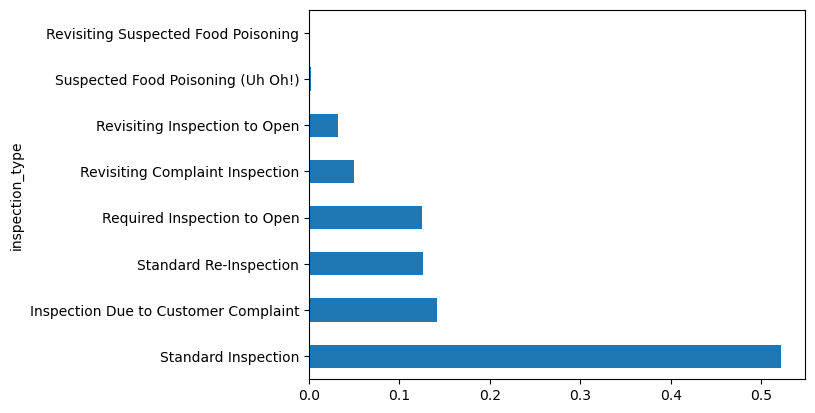

In [26]:
# Inspection Type Frequency
chicago['inspection_type'].value_counts(normalize = True).plot(kind = 'barh');

**Three Most Common Inspection Types (referenced in data dictionary provided)**

- Canvass: the most common type of inspection performed at a frequency relative to the `risk` of the establishment.
- License: when the inspection is done as a requirement for the establishment to receive its license to operate.
- Complaint: when the inspection is done in response to a complaint against the establishment.

**Re-inspections can occur for most of the inspection types.**

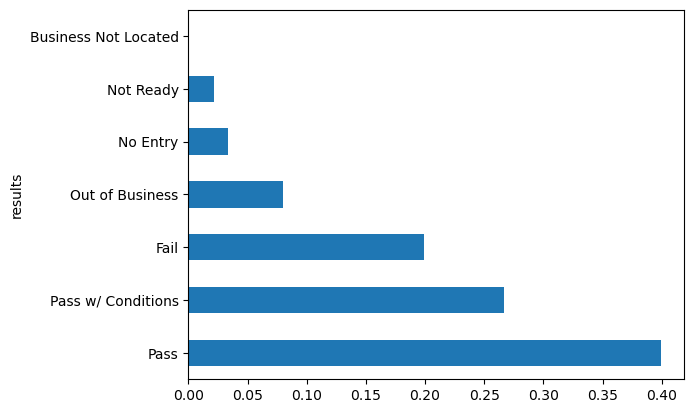

In [28]:
# Inspecton Results
chicago['results'].value_counts(normalize = True).plot(kind = 'barh');

- More than 40% of inspections result in a Pass
- Almost 1 in 5 inspections result in a Fail

In [30]:
# For the purposes of a simpler problem to tackle initially and for easier modelling, I will simplify the results to just Pass or Fail
chicago['results'] = chicago['results'].replace('Pass w/ Conditions', 'Pass')

# Now I will drop results which are not pass or fail
chicago = chicago[chicago['results'].isin(['Pass', 'Fail'])]
chicago.shape

(61705, 13)

- This method is risky as there is a possibility establishments who went out of business or deemed no entry could be re-opened later meaning they should not be removed from my dataset.
- A future workaround to this would be to search for the latest result by each establishment and check if they are still open as of latest inspection.
- I have not lost enough inspection rows to deem this is a necessary task at the moment, but it should be solved eventually.

In [32]:
# Assesing Risk Column
chicago['risk'].value_counts(normalize = True)

risk
Risk 1 (High)      0.837728
Risk 2 (Medium)    0.150020
Risk 3 (Low)       0.012252
Name: proportion, dtype: float64

- Risk 1 (High) being so frequent makes intuitive sense as inspections are performed at a rate relative to the risk factor, so this data would be biased to have higher risk establishments since they are inspected more frequently.

In [34]:
# Observing how violation field is formatted so I can determine how I'd like to parse the values
for violation in chicago['violations'][:3]:
    print(violation)
    print('='*60)

No Violations
39. CONTAMINATION PREVENTED DURING FOOD PREPARATION, STORAGE & DISPLAY - Comments: OBSERVED ICE SCOOP STORED IN VARIOUS ICE CONTAINERS. INSTRUCTED TO MAINTAIN SCOOP IN A CLEAN SANITIZED MANNER. | 39. CONTAMINATION PREVENTED DURING FOOD PREPARATION, STORAGE & DISPLAY - Comments:  ALL BEVERAGE DISPENSOR NOZZLES IN NEED OF CLEANING TO REMOVE ALL BUILD UP. INSTRUCTED TO CLEAN AND MAINTAIN. | 41. WIPING CLOTHS: PROPERLY USED & STORED - Comments:  ALL WIPING CLOTHS IN NEED OF STORING IN A CLEAN SANITIZING SOLUTION. INSTRUCTED TO CHANGE SOLUTION MORE FREQUENTLY. | 47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE, PROPERLY DESIGNED, CONSTRUCTED & USED - Comments: ALL STORAGE SHELVES ON FRONT SERVICE LINE AREA IN NEED OF CLEANING TO REMOVE ALL FOOD SPILLS. INSTRUCTED TO CLEAN AND MAINTAIN | 49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: FOOD EQUIPMENT IN NEED OF CLEANING TO REMOVE ALL FOOD SPILLS AND BUILD UP. INSTRUCTED TO CLEAN AND MAINTAIN.  | 53. TOILET FACILITIES: PROPERL

**Parsing Violation Notes**

- My first task is to extract only the violation code and descriptor elements of this submission, for example, if one violation is written as:

`49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: 4-601.11(C) : MUST CLEAN DUST BUILD UP AND DEBRIS FROM WINDOW SILLS,SERVICE COUNTER SHELVING UNITS,WALK IN COOLER-FAN GUARD COVERS AND SHELVING UNITS |`

- I would like to end up with: `49. NON-FOOD/FOOD CONTACT SURFACES CLEAN`

- There is an identifiable pattern in how the violations are written in which I can already see how I can pattern match to retreive the violation part alone: the violation code followed by a period and then the descriptor of the code, then a hyphen before Comments, then a separating bar (|) and the pattern is repeated for each violation.

*I can save it as a stretch goal for my app to evaluate the `Comments` section and display key words such as type of rodents found and type of contiminations.*

---
### Severity
- For the purposes of my app I would like to map these health codes to a severity level that is more 'real'.

- It will depend from county to county but I am using this capstone project to assess chicago's health codes and give them more realistic severity values.

- For example, while Chicago does not state having rodents as a critical violation, customers might change their mind on eating somewhere after finding out there is/were infestations.
I am using my domain knowledge and years of experience discussing what customers look for in a restaurant when they go out to eat in terms on cleanliness. This includes reading thousands and thousands of reviews and dealing with customers on a daily basis for many years. With this experience I can give a severity level to each health code of Chicago from 1 to 10.

In [37]:
def process_violations(violations):
    """
    Docstring Credit: ChatGPT
    Processes a string of violations and returns the count, violation codes, 
    and their associated severity levels.

    The function takes a string of health violation codes (from the Chicago Health Code) 
    and splits it into individual violation codes. It then determines the severity level 
    of each violation based on a predefined mapping. The severity levels range from 1 to 10, 
    with 10 being the most severe.

    Parameters:
    - violations (str): A string containing violation codes separated by " | ". 
                         If there are no violations, the string should be 'No Violations'.

    Returns:
    - tuple: A tuple containing the following elements:
        - violation_count (int): The number of violations found.
        - violations_list_code (list of int): A list of violation codes found in the input string.
        - severity_levels (list of int): A list of severity levels corresponding to each violation code.
    
    The function works as follows:
    1. If the input string is 'No Violations', it returns `0` for the violation count and empty lists 
       for the violation codes and severity levels.
    2. Otherwise, it splits the string by ' | ' and extracts the violation codes using regex.
    3. For each violation code, it maps it to its corresponding severity level using the `severity_map_reverse`.
       If a violation code does not exist in the mapping, it assigns a severity level of 0.

    Notes:
    ------
    - The `severity_map_reverse` defines a reverse lookup for violation codes to severity levels.
    - The function assumes that violation codes are always two digits or less.
    - The function uses regular expressions to extract violation codes from the input string.

    """
    # Chicago health codes grouped by severity level
    severity_map_reverse = {10: [3, 4, 5, 8, 9, 16, 17, 18, 19, 20, 28],
                        9: [21, 22],
                        8: [1, 2, 11, 13, 15, 52, 53],
                        7: [7, 25, 23, 27, 33, 34, 35, 40, 42, 46],
                        6: [10, 12, 14, 26, 29, 50],
                        5: [51, 56, 43, 44, 45, 47],
                        4: [30, 31, 36, 38, 39, 41, 48, 49],
                        3: [37, 24, 32, 60],
                        2: [6, 54],
                        1: [57, 58, 61, 62, 55, 59, 63]}

    if violations != 'No Violations':
        violations_list_str = violations.split(' | ')
        violation_count = len(violations_list_str)
        violations_list_code = [int(re.search(r'^\d{1,2}', v).group()) for v in violations_list_str]

        # Adding severity of each violation code found from above regex matching.
        severity_map = {code: severity for severity, violations_list_code in severity_map_reverse.items() for code in violations_list_code}
        severity_levels = [severity_map.get(code, 0) for code in violations_list_code]
    else:
        violation_count = 0
        violations_list_code = []
        severity_levels = []
    return violation_count, violations_list_code, severity_levels

In [38]:
# Apply the function to the main dataframe to generate new columns
chicago[['violation_count', 'violation_codes', 'severity_levels']] = chicago['violations'].apply(
    lambda x: pd.Series(process_violations(x))
)

In [39]:
# Next feature, whether the inspection is first or Re-Inspection
chicago['is_reinspection'] = chicago['inspection_type'].str.contains('Re-Inspection')

In [40]:
# Double check that my created features have been added properly.
chicago.head()

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,inspection_date,inspection_type,results,violations,name_cleaned,num_inspections,violation_count,violation_codes,severity_levels,is_reinspection
1,2606026,FAMOUS GRILL,SAM'S FAMOUS GRILL,2961604,Restaurant,Risk 1 (High),2926 W 63RD ST,2024-11-06,Required Inspection to Open,Pass,No Violations,SAMS FAMOUS GRILL,4,0,[],[],False
5,2605995,DUNKIN DONUTS,DUNKIN DONUTS,2835421,Restaurant,Risk 2 (Medium),1465 W 95TH ST,2024-11-06,Standard Re-Inspection,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,DUNKIN DONUTS,13,7,"[39, 39, 41, 47, 49, 53, 55]","[4, 4, 4, 5, 4, 8, 1]",True
6,2606039,STARBUCKS COFFEE #13710,STARBUCKS,1843207,Restaurant,Risk 2 (Medium),30 W ERIE ST,2024-11-06,Standard Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",STARBUCKS,8,4,"[38, 52, 55, 55]","[4, 8, 1, 1]",False
8,2606024,ANDINA COMFORT FOOD,ANDINA COMFORT FOOD,2997252,Restaurant,Risk 1 (High),2325 W TAYLOR ST,2024-11-06,Required Inspection to Open,Pass,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",ANDINA COMFORT FOOD,8,2,"[3, 58]","[10, 1]",False
11,2606040,UNCLE BEN'S GRILL,UNCLE BEN'S GRILL,2835481,Restaurant,Risk 1 (High),456 N DAMEN AVE,2024-11-06,Inspection Due to Customer Complaint,Pass,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,UNCLE BENS GRILL,10,6,"[2, 3, 9, 49, 55, 55]","[8, 10, 10, 4, 1, 1]",False


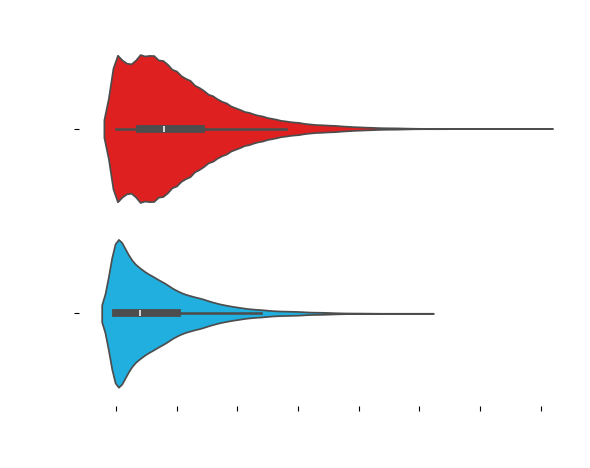

In [41]:
# Distribution of violation count depending if it is reinspection    
sns.violinplot(
    data=chicago,
    x='violation_count',  
    y='is_reinspection', 
    palette = {True: 'deepskyblue', False: 'red'},
    hue = 'is_reinspection',
    orient='h',
    legend = False
)

# Customize plot labels
plt.title('Did Violation Count Decrease After First Visit?', fontsize=16, color = 'white')
plt.xlabel('Violation Count', fontsize=16, color = 'white')
plt.ylabel('Re-Inspection (True/False)', fontsize=14, color = 'white')

# customize ticks
plt.xticks(color = 'white')
plt.yticks(color = 'white')

# Set the plot to be transparent
plt.gca().patch.set_alpha(0)  # Remove axis background
plt.gcf().patch.set_alpha(0)  # Remove figure background

# Remove plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False);

- Restaurants tend to fix most of their mistakes before getting re-inspected, as hoped!

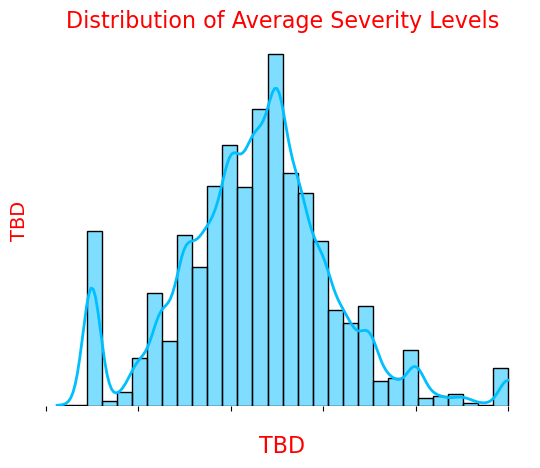

In [85]:
chicago['average_severity'] = chicago['severity_levels'].apply(lambda x: sum(x)/len(x) if len(x) > 0 else 0)
sns.histplot(chicago[chicago['average_severity'] > 0]['average_severity'],
             kde=True,
             bins = 30,
             color = 'deepskyblue',
             line_kws = {'color': 'red', 'linewidth': 2})


# Customize plot labels
plt.title('Distribution of Average Severity Levels', fontsize=16, color = 'red')
plt.xlabel('TBD', fontsize=16, color = 'red')
plt.ylabel('TBD', fontsize=14, color = 'red')

# customize ticks
plt.xticks(color = 'white')
plt.yticks([], [])

# Set the plot to be transparent
plt.gca().patch.set_alpha(0)  # Remove axis background
plt.gcf().patch.set_alpha(0)  # Remove figure background

# Remove plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False);

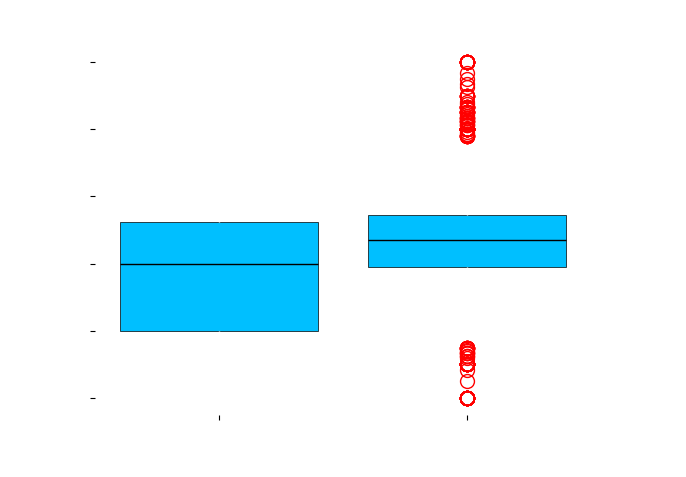

In [133]:
sns.boxplot(data=chicago, x='results', y='average_severity',
            flierprops = {'marker': 'o', 'markeredgecolor': 'red', 'markersize': 10},
            boxprops = {'facecolor': 'deepskyblue', 'edgecolor': 'black', 'linewidth': 0.5},
            medianprops = {'color': 'black'},
            whiskerprops = {'color': 'white', 'linewidth': 1},
            capprops = {'color': 'white', 'linewidth': 1})


# Customize plot labels
plt.title('Average Severity vs. Inspection Result', color = 'white', fontsize = 25)
plt.xlabel('TBD', fontsize=16, color = 'white')
plt.ylabel('TBD', fontsize=14, color = 'white')

# customize ticks
plt.xticks(color = 'white')
plt.yticks(color = 'white')

# Set the plot to be transparent
plt.gca().patch.set_alpha(0)  # Remove axis background
plt.gcf().patch.set_alpha(0)  # Remove figure background

# Remove plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False);

---
# Export Processed Data

In [47]:
chicago.to_csv('../../data/processed_chicago.csv', index = False)